In [1]:
import numpy as np 
import matplotlib.pyplot as plt 
#from qnetwork.dde import DDE_analytical
from qnetwork.multiphoton_ww import EmittersInWaveguideMultiphotonWW,Waveguide
from qnetwork.tools import set_plot_style

set_plot_style()

In [8]:
gamma= 0.01
L=2
c=1
positions=[0,L/2]
Delta=50.0

setup_ww=EmittersInWaveguideMultiphotonWW(positions=positions,gamma=gamma,Delta=Delta,L=L,c=c,setup=Waveguide.Ring)



In [30]:
t_ww,pop_ww=setup_ww.evolve(100,201,"10")
pop_ww=pop_ww.T


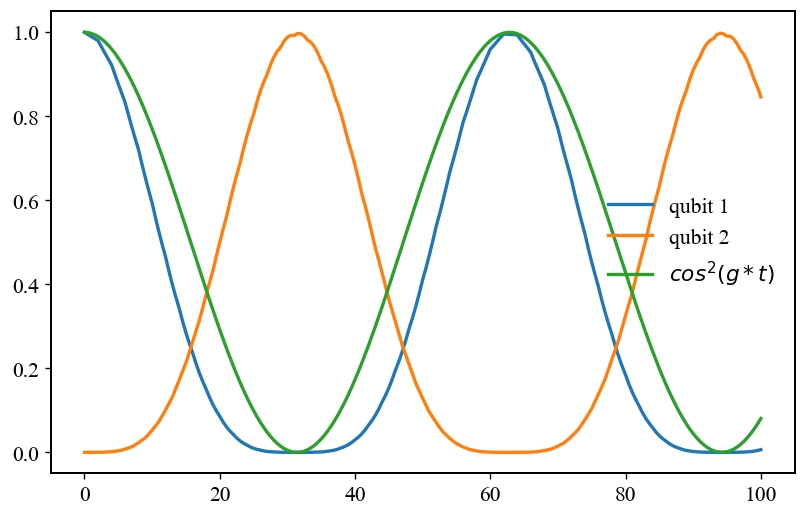

In [31]:
tau = 2*L/c 

plt.plot(t_ww,pop_ww[0],label='qubit 1')
plt.plot(t_ww,pop_ww[1],label='qubit 2')
plt.plot(t,np.cos(np.sqrt(gamma/(tau))*t)**2,label=r"$cos^{2}(g*t)$")
plt.legend()
plt.grid()
plt.show()

In [ ]:
from numpy.polynomial import Polynomial

def DDE_analytical(gamma,phi,tau,t):
	''' returns the analitycal solution for the DDE of a single emitter in a cavity'''
	
	alpha = 1j*phi/tau + 0.5*gamma 
	result =  np.exp(-alpha*t)*np.ones(len(t),dtype=complex)
	poli = Polynomial([1])
	N = int(t[-1]/tau)
	
	for n in range(1,N+1):
		dummie = poli.integ() 
		result += np.exp(-alpha*t)*np.exp(n*alpha*tau)*dummie(-gamma*(t-n*tau))*np.heaviside(t-n*tau,1)
		poli += dummie 

		
	return result 

def analytical_2_qubits_cavity(gamma:float, phi:float, tau:float, t: list |np.ndarray) : 
	
	c_plus=DDE_analytical(gamma=gamma,phi=phi,tau=tau,t=t)
	c_minus = DDE_analytical(gamma=gamma,phi=phi+np.pi,tau=tau,t=t)
	
	pop1=np.abs(0.5*(c_plus+c_minus))**2 
	pop2=np.abs(0.5*(c_plus-c_minus))**2
	return [np.real(pop1),np.real(pop2)]
	
	

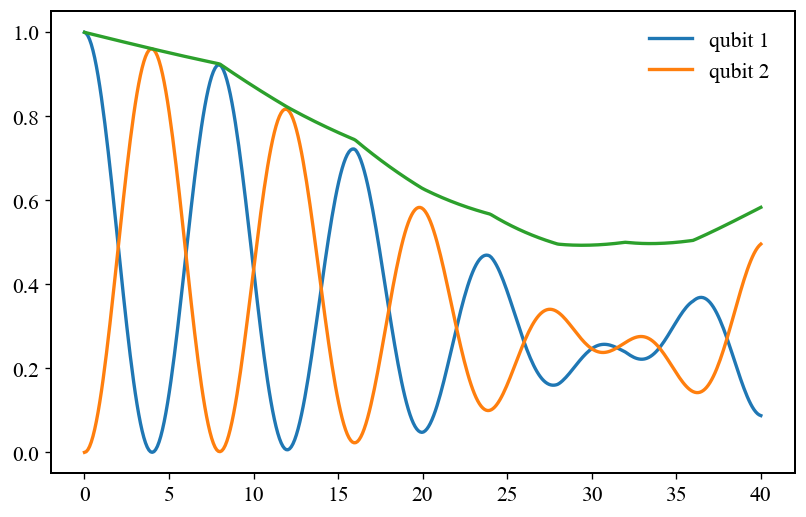

In [9]:
t=np.linspace(0,40,400)
tau=2*L/c
phi = 2*np.pi*Delta

data=analytical_2_qubits_cavity(gamma=gamma,phi=phi,tau=tau,t=t)

plt.plot(t,data[0],label='qubit 1')
plt.plot(t,data[1],label='qubit 2 ')
plt.plot(t,data[0]+data[1])
plt.legend()
plt.grid()
plt.show()

In [33]:
t=np.linspace(0,100,400)

c_plus=DDE_analytical(gamma=gamma,phi=phi,tau=tau,t=t)
c_minus = DDE_analytical(gamma=gamma,phi=phi+np.pi,tau=tau,t=t)

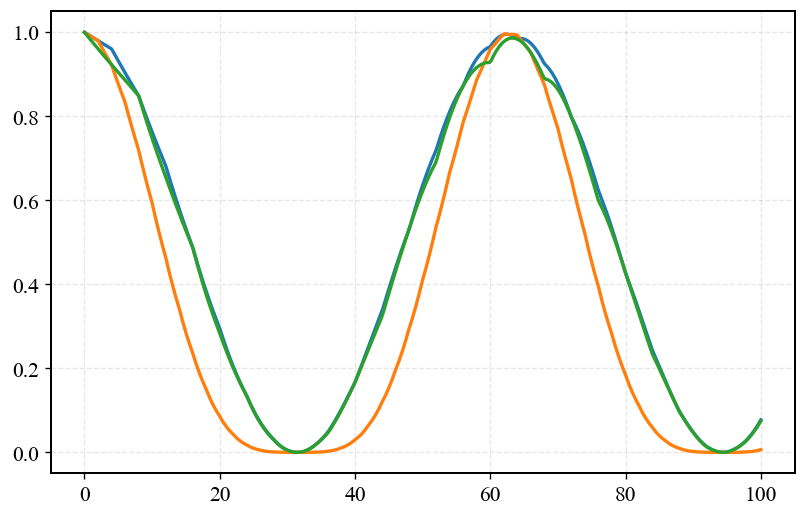

In [38]:
plt.plot(t,np.abs(c_plus)**2)
plt.plot(t_ww,pop_ww[0],label='qubit 1')
plt.plot(t,np.abs(np.conj(c_minus)*c_plus)**2)

In [6]:
gamma=0.04
phi=10*np.pi
L=1
c=1.2
tau=2*L/c

FSR = 2*np.pi / tau


positions=[0.0]
Delta=[phi/(2*np.pi)]
setup = EmittersInWaveguideMultiphotonWW(positions=positions,gamma=gamma,Delta=Delta,L=L,c=c)

In [7]:
t_max = 20
t,e=setup.evolve(t_max,initial_state="1")
e2 = DDE_analytical(gamma=gamma,phi=phi,tau=tau,t=t)

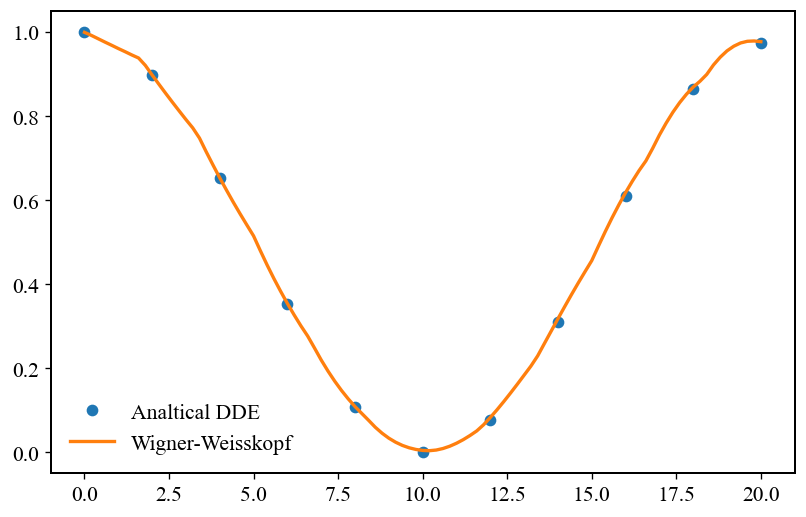

In [8]:
plt.plot(t,e2,'o',markevery=10,label='Analtical DDE ')
plt.plot(t,e,label='Wigner-Weisskopf')
plt.legend()
plt.grid()
plt.show()